# Import and functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import import_ipynb
import pandas as pd
import os

try:
    os.chdir('C:\\Users\\hydro_leo\\Documents\\GitHub\\python-code\\Modules')
    
except:
    os.chdir('C:\\Users\\llinc\\GitHub\\python-code\\Modules')
from SpatialTemporal_Correlation_and_Convolution import STconvolve
from SpatialTemporal_Correlation_and_Convolution import ST_STA
%matplotlib inline

importing Jupyter notebook from SpatialTemporal_Correlation_and_Convolution.ipynb


In [2]:
#This function deals with differentiation of angle within [-pi,pi).
#It will fail if angle array x change too fast.
def angular_gradient(x):
    diffx= np.gradient(x)
    diffx[np.abs(diffx)>0.6*np.pi] -= np.pi*diffx[np.abs(diffx)>0.6*np.pi]/abs(diffx[np.abs(diffx)>0.6*np.pi])
    return diffx

In [3]:
def ParaTrans(ASparadict, mag):     # because of overfitting, I assume alpha = mag*beta
    for k in ASparadict.keys():
        globals()[k] = ASparadict[k]
    global beta, alpha, g, l, Amp 
    
    beta = epsilon*2/(1+mag)
    alpha = epsilon*2*mag/(1+mag)
    g = omegastar**2 + (alpha-beta)**2 /4
    l = ((2*omegastar*np.tan(deltastar)*(-beta+gamma)+(alpha-beta)*(beta-gamma)+2*g)/
                (g*(-alpha-beta+2*gamma-2*omegastar*np.tan(deltastar))))
    Amp = Dmp*(g+alpha*beta-alpha*gamma-beta*gamma+gamma**2)/(-beta+gamma+g*l)
    DiffParadict = {'alpha':[], 'beta':[], 'gamma':[], 'g':[], 'l':[], 'tau_y':[], 'Amp':[], 'error':[]}
    for k in DiffParadict.keys():
        DiffParadict[k] = globals()[k]
    return DiffParadict

In [4]:
def Gaussian_filter_1d(x,s):
    return(np.exp(-(x/s)**2/2))/s/np.sqrt(np.pi*2)

def FB_FF_1l_1D(stimulus, sigma_dict, para_dict, dx, dt, IHeadto=50, HeadWeight=100):
    klen = min(max(sigma_dict.values())*3, int(stimulus.shape[1]/2/dx))
    xx = np.arange(-klen,klen+dx,dx)
    KC = Gaussian_filter_1d(xx,sigma_dict['C'])
    KH = Gaussian_filter_1d(xx,sigma_dict['H'])
    KB = Gaussian_filter_1d(xx,sigma_dict['B'])
    
    T  = np.arange(0,int(para_dict['tau_y']/dt*15))*dt
    Ky = T/para_dict['tau_y'] /para_dict['tau_y'] *np.exp(-T/para_dict['tau_y'])
    sstm = np.array([np.convolve(stimulus[:,j], Ky, 'full')[:stimulus.shape[0]]*dt for j in range(stimulus.shape[1])]).T

    zts = np.zeros_like(stimulus)#Cone
    yts = np.zeros_like(stimulus)#horizontal
    wts = np.zeros_like(stimulus)#Bipolar
    
    if IHeadto >=2: #Heavy Head 
        HeadTaxis = np.arange(IHeadto)*dt
        LongHeadTaxis = np.arange(0, IHeadto*dt-dt+dt/HeadWeight/2, dt/HeadWeight)
        HeadStimulus = interpolate.interp1d(HeadTaxis, sstm[:IHeadto,:], axis = 0)(LongHeadTaxis)
        Hzts = np.zeros_like(HeadStimulus)#horizontal
        Hyts = np.zeros_like(HeadStimulus)#horizontal
        Hwts = np.zeros_like(HeadStimulus)#horizontal
        for i in np.arange(np.shape(HeadStimulus)[0]-1):
            s = HeadStimulus[i,:]
            rs = np.convolve(s,KC,'same')*dx
            ry2z = np.convolve(Hyts[i,:],KH,'same')*dx# feedback from horizontal cell (y convoluted with horitonatl cell receptive field KH)
            dyj =(-para_dict['alpha']*Hyts[i,:]+(rs-Hzts[i,:]))*dt/HeadWeight
            dzj =(-para_dict['beta']*Hzts[i,:]+para_dict['g']*ry2z)*dt/HeadWeight
            ry2w = np.convolve(Hyts[i,:],KB,'same')*dx# feedback from horizontal cell (y convoluted with horitonatl cell receptive field KH)
            dwj =(-para_dict['gamma']*Hwts[i,:]+ry2w-para_dict['l']*Hzts[i,:])*dt/HeadWeight
            Hyts[i+1,:] = (Hyts[i,:]+dyj)
            Hzts[i+1,:] = (Hzts[i,:]+dzj)
            Hwts[i+1,:] = (Hwts[i,:]+dwj)
        yts[:IHeadto,:] = Hyts[::HeadWeight,:]
        zts[:IHeadto,:] = Hzts[::HeadWeight,:]
        wts[:IHeadto,:] = Hwts[::HeadWeight,:]

    for i in np.arange(IHeadto-1, np.shape(stimulus)[0]-1):
        s = sstm[i,:]
        rs = np.convolve(s,KC,'same')*dx
        ry2z = np.convolve(yts[i,:],KH,'same')*dx# feedback from horizontal cell (y convoluted with horitonatl cell receptive field KH)
        dyj =(-para_dict['alpha']*yts[i,:] +                rs   - zts[i,:])*dt
        dzj =(-para_dict['beta'] *zts[i,:] + para_dict['g']*ry2z)*dt
        ry2w = np.convolve(yts[i,:],KB,'same')*dx# feedback from horizontal cell (y convoluted with horitonatl cell receptive field KH)
        dwj =(-para_dict['gamma']*wts[i,:] +                ry2w - para_dict['l']*zts[i,:])*dt
        
        yts[i+1,:] = (yts[i,:]+dyj)
        zts[i+1,:] = (zts[i,:]+dzj)
        wts[i+1,:] = (wts[i,:]+dwj)
        
    return para_dict['Amp']*wts, zts, yts

In [5]:
def NGD2L_TK_AS(T, epsilon, gamma, omegastar, deltastar, tau_y, Dmp):
    dt = np.mean(np.diff(T))
    dt = dt/50
    T = np.arange(0, T[-1]+dt, dt)
    x = T/tau_y /tau_y *np.exp(-T/tau_y)*dt
    
    Kw = -Dmp*( 1/np.cos(deltastar)*np.exp(-epsilon*T)*np.cos(T*omegastar+deltastar) -np.exp(-gamma*T) )
    w = np.convolve(x, Kw, 'full')[:len(T):50]*dt
    return w/(dt)


def NGD2L_TK(T, alpha, beta, gamma, g, l, tau_y, Amp):
    dt = np.mean(np.diff(T))
    dt = dt/50
    T = np.arange(0, T[-1]+dt, dt)
    x = T/tau_y /tau_y *np.exp(-T/tau_y)*dt
    
    y=np.zeros_like(x)
    z=np.zeros_like(x)
    w=np.zeros_like(x)
    for j in range(len(x)-1):
        dy=dt*(-alpha*y[j] + x[j]-z[j] )
        dz=dt*(-beta* z[j] + g*y[j] )
        dw=dt*(-gamma*w[j] + y[j]-l*z[j] )
        y[j+1]=y[j]+dy
        z[j+1]=z[j]+dz
        w[j+1]=w[j]+dw

    return -Amp*w[::50]/(dt)


# Setting parameters from fitting real TK

In [6]:
loadfiles = np.load('D:\\GoogleDrive\\retina\\Chou\'s data\\20210513\\Analyzed_data\\fitNGD2LASpara.npz', allow_pickle=True)
for k in loadfiles.files:
    vars()[k] = loadfiles[k][()]
cn = 42
pd.DataFrame(para_dict).loc[cn-1]

epsilon      12.204853
gamma        25.657090
omegastar    30.082131
deltastar    -0.907297
tau_y         0.038977
Dmp           9.283163
error         2.836139
Name: 41, dtype: float64

In [7]:
FBFF_sigma_dict = dict()
FBFF_sigma_dict['H'] = 1
FBFF_sigma_dict['C'] = FBFF_sigma_dict['H']*0.1 # RF size of cone cell
FBFF_sigma_dict['B'] = FBFF_sigma_dict['H']*0.3

dx = FBFF_sigma_dict['H']/40.
# xlen = 20*FBFF_sigma_dict['H'] #spatial extend of simulation
xstep = 781
SKxaxis = np.arange(-int(xstep/2),int(xstep/2)+1)*dx


dt=1/60. #large dt will cause  overflow
nstep = int(1./dt)
TKtaxis = np.arange(nstep)*dt

FBFF_para_dict  = pd.DataFrame(ParaTrans(para_dict, 1)).loc[cn-1]

C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


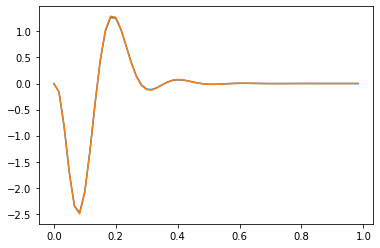

In [8]:
TKAS = NGD2L_TK_AS(TKtaxis, *pd.DataFrame(para_dict).loc[cn-1][:-1])
plt.plot(TKtaxis, TKAS)
plt.plot(TKtaxis, NGD2L_TK(TKtaxis, *FBFF_para_dict[:-1]))

In [9]:
FBFF_para_dict

alpha     12.204853
beta      12.204853
gamma     25.657090
g        904.934611
l          0.008240
tau_y      0.038977
Amp      482.110215
error      2.836139
Name: 41, dtype: float64

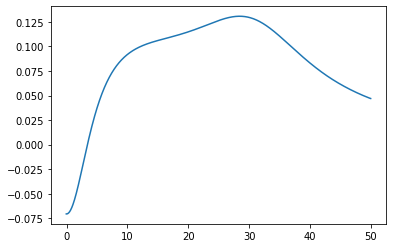

In [10]:
dOmega = 0.05
omega = np.arange(-dOmega,50,dOmega)
F_TK = np.sum(TKAS[np.newaxis,:]*np.exp(-1j*TKtaxis[np.newaxis,:]*omega[:,np.newaxis]), axis = 1)*dt
Phi = np.angle(F_TK)
delta = -angular_gradient(Phi)/dOmega
plt.plot(omega, delta)

In [11]:
wnmean = 15
wnstd = 2

# TK

In [12]:
TDelta_input = np.zeros([len(TKtaxis), xstep])
TDelta_input[0,:] = 1
TDelta_output_w, zts, TDelta_output_y = FB_FF_1l_1D(TDelta_input, FBFF_sigma_dict, FBFF_para_dict, dx, dt)

In [13]:
stilen = int(100/dt)
n_twn = np.random.randn(stilen)
n_twn = (n_twn - np.mean(n_twn))/np.std(n_twn)
TWN = (n_twn*wnstd + wnmean)[:, np.newaxis]*np.ones(xstep)[np.newaxis, :]
TWN_w, zts, TWN_y = FB_FF_1l_1D(TWN, FBFF_sigma_dict, FBFF_para_dict, dx, dt, IHeadto=stilen, HeadWeight=10)

In [14]:
Xcor = np.correlate(TWN_w[:,int(xstep/2)], n_twn,'same')/np.correlate(TWN_w[:,int(xstep/2)], np.ones(stilen), 'same')
wnTK = (Xcor[int(stilen/2):int(stilen/2)+60])/wnstd*wnmean/10/dt

delTK = TDelta_output_w[:len(TKtaxis),int(xstep/2)]/dt #normalized by height of delta function

Text(0.5, 1.0, 'temporal filter')

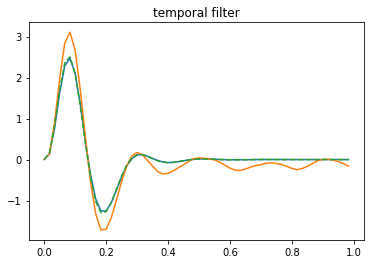

In [15]:
plt.plot(TKtaxis, delTK)
plt.plot(TKtaxis, wnTK)
plt.plot(TKtaxis, -NGD2L_TK(TKtaxis, *FBFF_para_dict[:-1]), '--')
plt.title('temporal filter')

In [16]:
max(wnTK)/max(delTK)

1.257697607467242

# SK

In [19]:
SDelta_input = np.zeros([nstep, xstep])
SDelta_input[:, int(xstep/2)] = 1
SDelta_output_w, zts, SDelta_output_y = FB_FF_1l_1D(SDelta_input, FBFF_sigma_dict, FBFF_para_dict, dx, dt)

Text(0.5, 1.0, 'spatial filter')

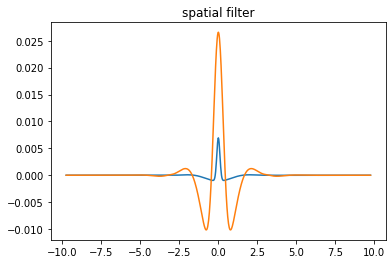

In [20]:
plt.plot(SKxaxis, SDelta_output_y[-1,:])
plt.plot(SKxaxis, SDelta_output_w[-1,:])

plt.title('spatial filter')

In [21]:
delSK = SDelta_output_y[-1,:]/dx

# STK

In [22]:
Delta_input = np.zeros([nstep, xstep])
Delta_input[0, int(xstep/2)] = 1
Delta_output_w, zts, Delta_output_y = FB_FF_1l_1D(Delta_input, FBFF_sigma_dict, FBFF_para_dict, dx, dt)

In [23]:
mother = np.append(np.ones(36), np.zeros(35))
checkerbroard = []
for i in range(2*60*30):
    np.random.shuffle(mother) 
    checkerbroard.append(mother.copy())
checkerbroard = np.repeat(checkerbroard, 2, axis=0)
checkerbroard = np.repeat(checkerbroard, 11, axis=1)

In [25]:
CB_w, zts, CB_y = FB_FF_1l_1D(checkerbroard, FBFF_sigma_dict, FBFF_para_dict, dx, dt,
                              IHeadto=checkerbroard.shape[0], HeadWeight=10)

In [26]:
x_c = checkerbroard
x_c = x_c-np.mean(x_c, axis = 0)

STkernel = np.zeros([60,checkerbroard.shape[1]])
Denominator = np.zeros([60,checkerbroard.shape[1]])
for i in range(60):
    for ii in np.arange(0, checkerbroard.shape[0]-i):
        STkernel[i,:] += np.correlate(CB_w[i+ii,:],x_c[ii, :],'same')*dx*dt
        Denominator[i,:] += np.correlate(CB_w[i+ii,:],np.ones_like(x_c[ii, :]),'same')*dx*dt
        
WNSTK = STkernel/Denominator

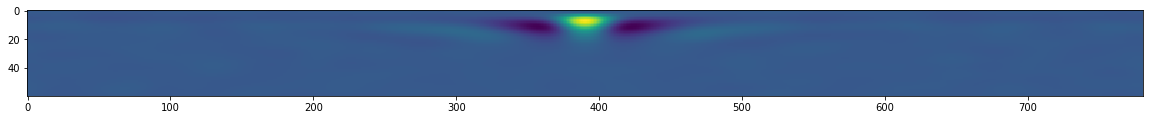

In [27]:
plt.imshow(WNSTK)
plt.gcf().set_size_inches(20, 5)

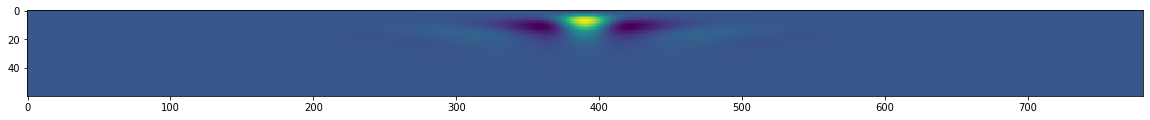

In [28]:
plt.imshow(Delta_output_w)
plt.gcf().set_size_inches(20, 5)

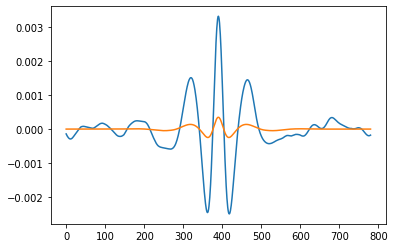

In [29]:
plt.plot(WNSTK[20,:]/10)
plt.plot(Delta_output_w[20,:])

In [30]:
delSTK = Delta_output_y/dt/dx

# Separate by Integration

In [ ]:
iTK = np.sum(delSTK, axis = 1)*dx
iSK = np.sum(delSTK, axis = 0)*dt

In [ ]:
plt.plot(SKxaxis, iSK)
plt.plot(SKxaxis, delSK)
plt.title('spatial filter')

plt.legend( ('iSk', r'$\delta Sk$'), loc='best', prop={'size': 'large', 'family': 'monospace'})

In [ ]:
plt.plot(TKtaxis, iTK)
plt.plot(TKtaxis, delTK)
plt.grid()

plt.title('temporal filter')

plt.legend( ('iTk', r'$\delta Tk$'), loc='best', prop={'size': 'large', 'family': 'monospace'})

In [ ]:
SeSTK = iTK[:, np.newaxis]*iSK[np.newaxis,:]

In [ ]:
plt.imshow(SeSTK)
plt.colorbar()
plt.title('Separatable S-T-filter')
fig = plt.gcf()
fig.set_size_inches(20, 5)

# Apply SVD on Spatial-Temporal Kernel

In [39]:
from numpy import linalg as la
U,sigma,VT=la.svd(WNSTK)
#U and VT are unitary martrices, So U1 and V1 are normalized vector 

In [40]:
(sigma/sum(sigma))[:5]
if sum(VT[0,:]) <0:
    VT = -VT
    U = -U

In [41]:
sigma/np.sum(sigma)

array([5.67639273e-01, 2.15416531e-01, 7.38576711e-02, 3.09582013e-02,
       2.29100418e-02, 2.00313685e-02, 1.54598829e-02, 1.21918795e-02,
       1.06242487e-02, 6.93430785e-03, 5.95497500e-03, 4.63133776e-03,
       3.18578972e-03, 2.58671869e-03, 1.77080983e-03, 1.19800251e-03,
       1.06629078e-03, 7.59224037e-04, 6.13517422e-04, 4.38391168e-04,
       3.88525723e-04, 2.94458716e-04, 1.93384153e-04, 1.56737328e-04,
       1.54477136e-04, 1.03780919e-04, 8.95563386e-05, 7.54133007e-05,
       7.14627142e-05, 3.73847640e-05, 3.39848682e-05, 2.77998975e-05,
       2.41292233e-05, 1.93948833e-05, 1.60853371e-05, 1.41553340e-05,
       1.18599402e-05, 1.00113895e-05, 8.28886056e-06, 6.47424615e-06,
       5.46331657e-06, 4.62916407e-06, 4.15275161e-06, 3.87509907e-06,
       3.40994938e-06, 2.71818557e-06, 2.33170713e-06, 1.84825518e-06,
       1.36077412e-06, 9.27553958e-07, 6.93375151e-07, 6.50018228e-07,
       5.77999776e-07, 4.32129341e-07, 3.32934731e-07, 3.12152248e-07,
      

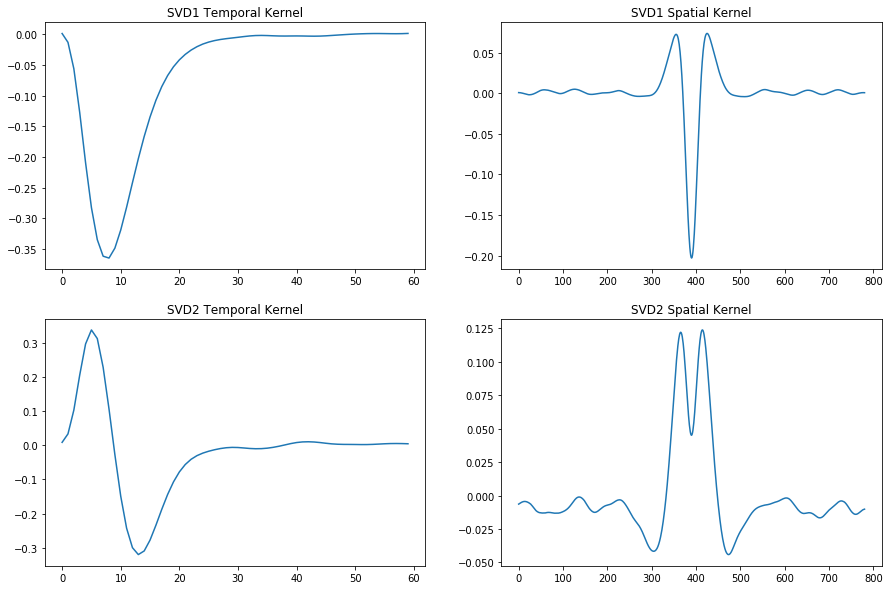

In [42]:
fig, ((ax2, ax3), (ax4, ax5)) = plt.subplots(nrows=2, ncols=2)
ax2.plot(U[:,0])
ax2.set_title('SVD1 Temporal Kernel')
ax3.plot(VT[0,:])
ax3.set_title('SVD1 Spatial Kernel')
ax4.plot(U[:,1])
ax4.set_title('SVD2 Temporal Kernel')
ax5.plot(VT[1,:])
ax5.set_title('SVD2 Spatial Kernel')
fig.set_size_inches(15, 10)

In [ ]:
plt.plot(SKxaxis, iSK, label = 'iSk')
plt.plot(SKxaxis, delSK, label = r'$\delta Sk$')
plt.plot(SKxaxis, VT[0,:]*np.sqrt(sigma[0]), label = 'SVD1')
plt.plot(SKxaxis, VT[1,:]*np.sqrt(sigma[1]), label = 'SVD2')

plt.title('spatial filter')
plt.legend(loc='best', prop={'size': 'large', 'family': 'monospace'})

In [ ]:
plt.plot(TKtaxis, iTK)
plt.plot(TKtaxis, delTK)
plt.plot(TKtaxis, U[:,0]*np.sqrt(sigma[0]))
plt.plot(TKtaxis, U[:,1]*np.sqrt(sigma[1]))
plt.grid()

plt.title('temporal filter')

plt.legend( ('iTk', 'cSTA', 'SVD1', 'SVD2'), loc='best', prop={'size': 'large', 'family': 'monospace'})

In [ ]:
cSVD = 0
SVDSTK = U[:,cSVD][:, np.newaxis]*VT[cSVD,:][np.newaxis, :]*sigma[cSVD]
plt.imshow(SVDSTK)
plt.title('SVD'+str(cSVD+1)+'-reconstructed STKernel')
fig = plt.gcf()
fig.set_size_inches(20, 5)

In [ ]:
fig, ax = plt.subplots(3,1)
ax[0].imshow(delSTK)
ax[0].set_title('STK')
ax[1].imshow(SeSTK)
ax[1].set_title('SeSTK')
ax[2].imshow(SVDSTK)
ax[2].set_title('SVDSTK')
plt.gcf().set_size_inches(20, 5)

Rs2d = np.max(delSTK)/np.max(SeSTK)

In [ ]:
plt.imshow(delSTK)
plt.colorbar(orientation="horizontal")
plt.gcf().set_size_inches(20, 10)

In [ ]:
plt.imshow(SeSTK)
plt.colorbar(orientation="horizontal")
plt.gcf().set_size_inches(20, 10)

In [ ]:
plt.imshow(SVDSTK)
plt.colorbar(orientation="horizontal")
plt.gcf().set_size_inches(20, 10)

In [ ]:
KC = Gaussian_filter_1d(SKxaxis,FBFF_sigma_dict['C'])
KH = Gaussian_filter_1d(SKxaxis,FBFF_sigma_dict['H'])
KB = Gaussian_filter_1d(SKxaxis,FBFF_sigma_dict['B'])
plt.plot(SKxaxis, KC, label = 'cone')
plt.plot(SKxaxis, KH, label = 'horizontal')
plt.plot(SKxaxis, KB, label = 'bipolar')
plt.plot(SKxaxis, KC-KH, label = 'DoG')
plt.plot(SKxaxis, VT[0,:]/max(VT[0,:])*max(KB), label = 'SVD1')

plt.xlim([-5,5])
plt.legend()

In [ ]:
from scipy.optimize import curve_fit
SK = VT[0,:]

def DoG(x, a1, sigma1, a2, sigma2):
    return a1*Gaussian_filter_1d(x,sigma1)-a2*Gaussian_filter_1d(x,sigma2)

popt,pcov = curve_fit(DoG, SKxaxis, SK, p0=[max(SK), 23, 0.1*max(SK), 5*23], bounds = (0, np.inf))
# popt,pcov = curve_fit(DoG, SKxaxis, SK, p0=[max(SK)/2, 23, -0.1*max(SK), 5*23])
print(popt*dx)

plt.plot(SKxaxis, SK, 'b+:', label='data')
plt.plot(SKxaxis,  DoG(SKxaxis, *popt), 'r-', label='fit')
plt.legend()

In [ ]:
print(popt)
FBFF_sigma_dict

In [ ]:
0.1/dx